### Capstone I
**Goal:** The goal of this project is to identify better ways to detect people at risk for suicide. We will be training several classification models (Naive Bayes, Logistic Regression, Decision Trees, SVC, KNN) to detect suicide ideation from social media posts and comparing their performances.  

**Data Problem**: The data task is to train and tune multiple binary text classification models to group social media posts into suicidal vs non-suicidal classes. Models with high accuracy will be used to predict, from future/unseen posts, whether their writer is at risk for suicide. We will further scrutinize the predictive models to find the optimal features and parameters, then identify measures to more effectively detect suicide ideation. 


**Data**

The data is sourced from Kaggle 

Link: https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch 


- The data are a collection of posts collected from the 'SuicideWatch' and 'teenagers' subreddits from the Reddit platform using PushshiftAPI
- Posts were created between 16 December 2008 - 2 January 2021
- Social media posts collected from the 'SuicideWatch' subreddit are labelled 'suicide', while posts collected from 'teenagers' are labelled 'non-suicide'



#### Import and Setup

In [137]:
import nltk
import time
import eli5
import string
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords 
from nltk import word_tokenize, sent_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
sns.set_style("whitegrid")
sns.set_palette("rocket")
warnings.simplefilter(action='ignore')

In [28]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/lois/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lois/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lois/nltk_data...


True

#### Data Overview
- 232074 samples/rows 
- 3 columns: 
       1. Unnamed: 0: A unique ID for each row 
       2. text: Content of the social media post
       3. class: Whether the poster is suicidal or not; values: ['suicide', 'non-suicide']

In [7]:
suicide = pd.read_csv("/Users/Lois/Downloads/ML ipynb/Capstone/SuicideDetection.csv")

In [8]:
print(suicide.shape)
suicide.head()

(232074, 3)


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [9]:
#using a random sample of 20,000 entries for model training
suicide = suicide.sample(20000, random_state = 42)

In [10]:
#sample suicidal post
print('Class:', suicide['class'].iloc[0])
suicide['text'].iloc[0]

Class: suicide


"I Don't know?7? Months self harm free and the urge just gets stronger and stronger every day. The past few days I've just been shit... \nMy family stresses me out especially my nephew (he's 12) My mum has full custody of him and he's told me to go kill myself numerous times.. I wish it was that easy.\nMy partners family stresses me out especially over the past few days. \nStress is my trigger \nI just want to scream and cry. \nI live near the woods so I could go out and scream till I can't possibly scream anymore but the cops will probably get called...\nMy OH knows about my depression but he doesn't really know how I'm feeling at the moment. He would want to come over and make sure I'm OK but he's fucking annoying. He annoys me all the time by doing small stupid things. \nI don't even know where I'm going with the post? \n\n"

In [11]:
#sample non-suicidal post
print('Class:', suicide['class'].iloc[1])
suicide['text'].iloc[1]

Class: non-suicide


'I HAVE TO START BECOMING RICH I HAVE TO START MY COMPANY SO WHEN I BECOME 16 I CAN AFFORD A BIG VAN AND GO ON TRIPS WITH MY FRIENDS BUT I HAVE NO TIME LEFT I HAVE TO START WORKING'

#### Exploratory Data Analysis

In [12]:
suicide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 74414 to 89712
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20000 non-null  int64 
 1   text        20000 non-null  object
 2   class       20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 625.0+ KB


In [13]:
#no null values
suicide.isna().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

In [14]:
#summary statistics
suicide['char_count'] = suicide.text.apply(len)
print('Mean character count:', suicide['char_count'].mean())
print('Min character count:', suicide['char_count'].min())
print('Max character count:', suicide['char_count'].max())

Mean character count: 680.14645
Min character count: 7
Max character count: 40106


(0.0, 10000.0)

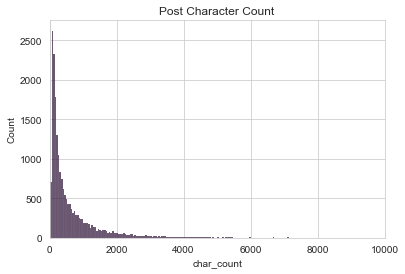

In [15]:
#character count visualization
fig, ax = plt.subplots()
sns.histplot(suicide['char_count'], ax = ax).set_title('Post Character Count')
ax.set_xlim(0, 10000)

In [16]:
#most frequent words in both classes 
suicide_words = list(suicide[suicide['class'] == 'suicide'].text.values)
non_suicide_words = list(suicide[suicide['class'] == 'non-suicide'].text.values)

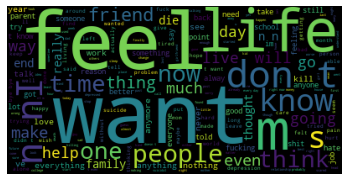

In [17]:
#suicide word cloud 
s_wordcloud = WordCloud(stopwords = STOPWORDS).generate(str(suicide_words))
plt.imshow(s_wordcloud)
plt.axis('off')
plt.show()

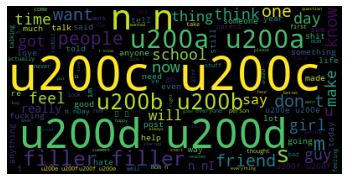

In [18]:
#non-suicide word cloud 
x_wordcloud = WordCloud(stopwords = STOPWORDS).generate(str(non_suicide_words))
plt.imshow(x_wordcloud)
plt.axis('off')
plt.show()

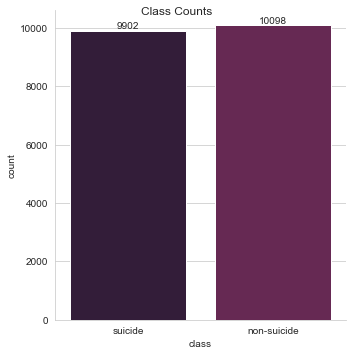

In [19]:
#checking class distribution 

fig = sns.catplot(x = 'class', kind = 'count', data = suicide)
fig.fig.suptitle("Class Counts")
for fig in fig.axes.flat:
    fig.bar_label(fig.containers[0])

The data is balanced: Comparable counts of suicide and non-suicide posts

#### Data Setup

In [20]:
#only keeping the text and class columns
suicide.drop("Unnamed: 0", axis = 1, inplace = True)

#renaming "class" column as "suicide"
suicide.rename({"class" : "suicide"}, axis = 1, inplace = True)

#numerically representing "suicide" column
suicide.replace({"suicide" : 1, "non-suicide" : 0}, inplace = True)
suicide.head()

,text,suicide,char_count
74414,I Don't know?7? Months self harm free and the ...,1,828
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,0,179
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",0,96
14043,I've honestly got no idea what to do anymore.I...,1,1089
30673,Do you ever just cry? Like you just think abou...,0,268


In [21]:
#train test split
X = suicide['text']
y = suicide['suicide']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#### Text Preprocessing

In [51]:
#tokenization, lower casing, stop word removal
def preprocess_text(text):
    tokenizer = TweetTokenizer(preserve_case = False)
    swords = stopwords.words('english')
    
    proprocessed_text = []
    for entry in text:
        tokens = tokenizer.tokenize(entry)
        proprocessed_text.append([word for word in tokens if word not in swords])
    return proprocessed_text

In [71]:
pX_train = preprocess_text(X_train)

In [104]:
pX_test = preprocess_text(X_test)

In [106]:
#checking output 
pX_train[0]

['first',
 'gun',
 'last',
 'gunbuying',
 'first',
 'gun',
 'tomorrow',
 '.',
 'problems',
 '.',
 'hopefully',
 'get',
 'courage',
 'use',
 'next',
 'couple',
 'days',
 '.',
 'overdoses',
 '.',
 'medical',
 'bills',
 '.']

In [98]:
#converting pX_train and pX_test to a list of strings 
X_train = [' '.join(x) for x in pX_train]

In [99]:
#checking output
X_train[0]

'first gun last gunbuying first gun tomorrow . problems . hopefully get courage use next couple days . overdoses . medical bills .'

#### Feature Engineering 
Lemmatizing and TF-IDF 

In [100]:
lem = WordNetLemmatizer()
analyzer = TfidfVectorizer(lowercase = False).build_analyzer()

def lemmatizer(text):
    return (lem.lemmatize(w) for w in analyzer(text))

#### Model Training 

Holdout cross validation is implemented; models will be trained on the training set and validated with the test set.

RandomizedSearchCV is used to find the optimal number of features for model training.

We will be evaluating the models with the accuracy score metric because we have a balanced dataset. Accuracy measures the proportion of correctly predicted observations out of total observations and is calculated as (True Positive count + True Negative count) / (Total count), or

$$
\frac{TP + TN}{TP + TN + FP + FN}
$$


In [ ]:
#grid search dict

tf_params = {'tfidf__max_features': [1000, 2000, 3000],
            'tfidf__analyzer' : ['word', lemmatizer]}

**Naïve Bayes** 

In [146]:
#nb + tfidf 
nb_tf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('bayes', MultinomialNB())
])

In [147]:
#gridsearch max features 
nb_tf_grid = RandomizedSearchCV(estimator = nb_tf,
                   param_distributions = tf_params)

#fit
start = time.time()
nb_tf_grid.fit(X_train, y_train)
stop = time.time()

#stats
nb_tf_time = stop - start
nb_tf_acc = nb_tf_grid.score(X_test, y_test)
nb_tf_params = nb_tf_grid.best_params_

**Logistic Regression**

In [111]:
#logreg + tfidf 
lgr_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lgr', LogisticRegression())
])

#gridsearch max features 
lgr_tf_grid = RandomizedSearchCV(estimator = lgr_tf,
                   param_distributions = tf_params)

#fit
start = time.time()
lgr_tf_grid.fit(X_train, y_train)
stop = time.time()

#stats
lgr_tf_time = stop - start
lgr_tf_acc = lgr_tf_grid.score(X_test, y_test)
lgr_tf_params = lgr_tf_grid.best_params_

**Decision Tree**

In [113]:
#dtree + tfidf 
tree_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('dtree', DecisionTreeClassifier())
])

#gridsearch max features 
tree_tf_grid = RandomizedSearchCV(estimator = tree_tf,
                   param_distributions = tf_params)

#fit
start = time.time()
tree_tf_grid.fit(X_train, y_train)
stop = time.time()

#stats
tree_tf_time = stop - start
tree_tf_acc = tree_tf_grid.score(X_test, y_test)
tree_tf_params = tree_tf_grid.best_params_

**Support Vector Machine**

In [119]:
#svc
svc_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

#gridsearch max features 
svc_tf_grid = RandomizedSearchCV(estimator = svc_tf,
                   param_distributions = tf_params)

#fit
start = time.time()
svc_tf_grid.fit(X_train, y_train)
stop = time.time()

#stats
svc_tf_time = stop - start
svc_tf_acc = svc_tf_grid.score(X_test, y_test)
svc_tf_params = svc_tf_grid.best_params_

**K-Nearest Neighbors**

In [121]:
#knn
knn_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

#gridsearch max features 
knn_tf_grid = RandomizedSearchCV(estimator = knn_tf,
                   param_distributions = tf_params)

#fit
start = time.time()
knn_tf_grid.fit(X_train, y_train)
stop = time.time()

#stats
knn_tf_time = stop - start
knn_tf_acc = knn_tf_grid.score(X_test, y_test)
knn_tf_params = knn_tf_grid.best_params_

**Results**

Logistic Regression has the highest accuracy score of 0.896, followed by SVC (0.886) and Naive Bayes (0.812)

In [141]:
#build df 
lem_df = pd.DataFrame({'model': ['Decision Tree', 'Logistic', 'Bayes', 'SVC', 'KNN'], 
              'speed' : [tree_tf_time, lgr_tf_time, nb_tf_time, svc_tf_time, knn_tf_time],
              'best_params': [tree_tf_params, lgr_tf_params, nb_tf_params, svc_tf_params, knn_tf_params],
              'best_score': [tree_tf_acc, lgr_tf_acc, nb_tf_acc, svc_tf_acc, knn_tf_acc]}).set_index('model')

lem_df.sort_values('best_score')

,speed,best_params,best_score
model,,,
KNN,101.769575,"{'tfidf__max_features': 1000, 'tfidf__analyzer...",0.512000
Decision Tree,143.554728,"{'tfidf__max_features': 3000, 'tfidf__analyzer...",0.774000
Bayes,62.889879,"{'tfidf__max_features': 3000, 'tfidf__analyzer...",0.812167
SVC,532.921001,"{'tfidf__max_features': 3000, 'tfidf__analyzer...",0.885667
Logistic,66.071181,"{'tfidf__max_features': 3000, 'tfidf__analyzer...",0.896333


Every model except for KNN has 3000 max_features as the optimal number.   

    

#### Repeating the process with stemmed data

In [148]:
#stemming + TF-IDF
stem = PorterStemmer()
sanalyzer = TfidfVectorizer(lowercase = False).build_analyzer()

def stemmer(text):
    return (stemmer.stem(w) for w in sanalyzer(text))

In [149]:
stem_params = {'tfidf__max_features': [1000, 2000, 3000],
            'tfidf__analyzer' : ['word', stemmer]}

**Naive Bayes**

In [150]:
#nb 
nb_stem = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('bayes', MultinomialNB())
])

In [151]:
#gridsearch max features 
nb_stem_grid = RandomizedSearchCV(estimator = nb_stem,
                   param_distributions = stem_params)

#fit
start = time.time()
nb_stem_grid.fit(X_train, y_train)
stop = time.time()

#stats
nb_stem_time = stop - start
nb_stem_acc = nb_stem_grid.score(X_test, y_test)
nb_stem_params = nb_stem_grid.best_params_

**Logistic Regression**

In [156]:
lgr_stem = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('lgr', LogisticRegression())
])

In [158]:
#gridsearch max features 
lgr_stem_grid = RandomizedSearchCV(estimator = lgr_stem,
                   param_distributions = stem_params)

#fit
start = time.time()
lgr_stem_grid.fit(X_train, y_train)
stop = time.time()

#stats
lgr_stem_time = stop - start
lgr_stem_acc = lgr_stem_grid.score(X_test, y_test)
lgr_stem_params = lgr_stem_grid.best_params_

**Decision Tree**

In [164]:
tree_stem = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('tree', DecisionTreeClassifier())
])

In [165]:
#gridsearch max features 
tree_stem_grid = RandomizedSearchCV(estimator = tree_stem,
                   param_distributions = stem_params)

#fit
start = time.time()
tree_stem_grid.fit(X_train, y_train)
stop = time.time()

#stats
tree_stem_time = stop - start
tree_stem_acc = tree_stem_grid.score(X_test, y_test)
tree_stem_params = tree_stem_grid.best_params_

**Suppport Vector Machine**

In [167]:
svc_stem = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('svc', SVC())
])

In [168]:
#gridsearch max features 
svc_stem_grid = RandomizedSearchCV(estimator = svc_stem,
                   param_distributions = stem_params)

#fit
start = time.time()
svc_stem_grid.fit(X_train, y_train)
stop = time.time()

#stats
svc_stem_time = stop - start
svc_stem_acc = svc_stem_grid.score(X_test, y_test)
svc_stem_params = svc_stem_grid.best_params_

**K-Neareset Neighbors**

In [172]:
knn_stem = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('knn', KNeighborsClassifier())
])

In [173]:
#gridsearch max features 
knn_stem_grid = RandomizedSearchCV(estimator = knn_stem,
                   param_distributions = stem_params)

#fit
start = time.time()
knn_stem_grid.fit(X_train, y_train)
stop = time.time()

#stats
knn_stem_time = stop - start
knn_stem_acc = knn_stem_grid.score(X_test, y_test)
knn_stem_params = knn_stem_grid.best_params_

**Results**

In [175]:
#build df 
stem_df = pd.DataFrame({'model': ['Decision Tree', 'Logistic', 'Bayes', 'SVC', 'KNN'], 
              'speed' : [tree_stem_time, lgr_stem_time, nb_stem_time, svc_stem_time, knn_stem_time],
              'best_params': [tree_stem_params, lgr_stem_params, nb_stem_params, svc_stem_params, knn_stem_params],
              'best_score': [tree_stem_acc, lgr_stem_acc, nb_stem_acc, svc_stem_acc, knn_stem_acc]}).set_index('model')

stem_df.sort_values('best_score')

,speed,best_params,best_score
model,,,
KNN,29.207217,"{'tfidf__max_features': 1000, 'tfidf__analyzer...",0.508167
Decision Tree,52.787727,"{'tfidf__max_features': 3000, 'tfidf__analyzer...",0.767833
Bayes,10.407821,"{'tfidf__max_features': 3000, 'tfidf__analyzer...",0.815833
SVC,268.433991,"{'tfidf__max_features': 3000, 'tfidf__analyzer...",0.887667
Logistic,11.400747,"{'tfidf__max_features': 3000, 'tfidf__analyzer...",0.894167


#### Comparing Stemming vs Lemmatization

The biggest difference between stemming and lemmatizing is the training time: stemming is significantly faster than lemmatizing. The optimal max_features value is the same as with the lemmatized data; 3000 is the best number for every model except KNN. Accuracy scores are similar, but KNN, Decision Tree, and Logistic Regression had higher accuracy scores when trained on lemmatized data while SVC and Naive Bayes had higher accuracy scores when trained on stemmed data. 

**Comparing Confusion Matrices**

Confusion matrices indicate the counts of the type of error each model made in the classification task. In these plots, 0 = not suicidal and 1 = suicidal. We will be comparing the confusion matrices of the highest version of each model. 

- The Logistic Regression model has more false negatives than false positives 
- The Naive Bayes model has significantly more false positives than false negatives
- The Decision Tree model has more false positives than false negatives
- The SVC model has slightly more false positives than false negatives 
- The KNN model has significantly more false negatives than false positives


Given the goal of this classification problem, it is better to have a higher false positive count than a false negative count. Although Naive Bayes has an accuracy score of .82, it is worth further scrutiny due to its low false negative count. These top three models, especially Logistic Regression and SVC, will be grid searched to minimize recall. 

(This analysis will be continued in the Capstone2 notebook)

In [177]:
#collecting predictions
log_preds = lgr_tf_grid.predict(X_test)
nb_preds = nb_stem_grid.predict(X_test)
tree_preds = tree_tf_grid.predict(X_test)
svc_preds = svc_stem_grid.predict(X_test)
knn_preds = knn_tf_grid.predict(X_test)

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

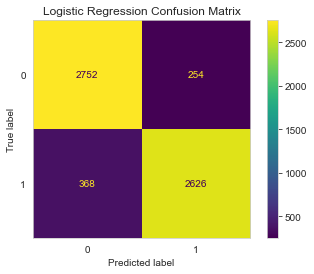

In [183]:
#logreg 
ConfusionMatrixDisplay(confusion_matrix(y_test, log_preds)).plot()
plt.grid(False)
plt.title("Logistic Regression Confusion Matrix")

Text(0.5, 1.0, 'Naive Bayes Confusion Matrix')

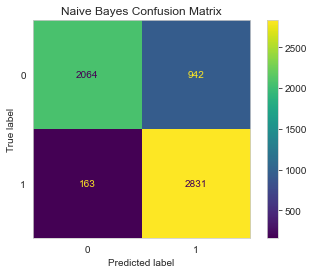

In [182]:
#naive bayes
ConfusionMatrixDisplay(confusion_matrix(y_test, nb_preds)).plot()
plt.grid(False)
plt.title("Naive Bayes Confusion Matrix")

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

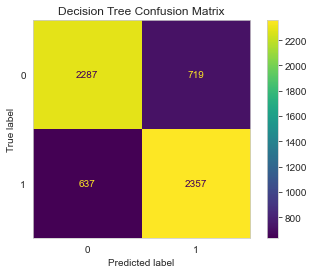

In [179]:
#decision tree
ConfusionMatrixDisplay(confusion_matrix(y_test, tree_preds)).plot()
plt.grid(False)
plt.title("Decision Tree Confusion Matrix")

Text(0.5, 1.0, 'SVC Confusion Matrix')

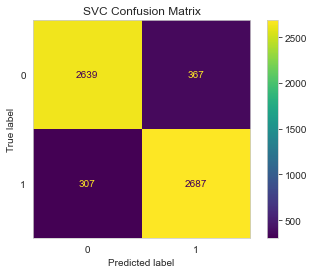

In [180]:
#svc
ConfusionMatrixDisplay(confusion_matrix(y_test, svc_preds)).plot()
plt.grid(False)
plt.title("SVC Confusion Matrix")

Text(0.5, 1.0, 'KNN Confusion Matrix')

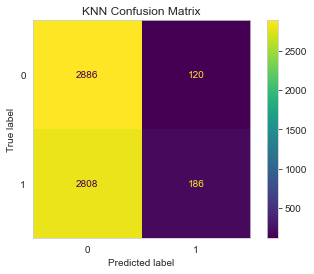

In [178]:
#knn
ConfusionMatrixDisplay(confusion_matrix(y_test, knn_preds)).plot()
plt.grid(False)
plt.title("KNN Confusion Matrix")